 #### 분석 목표
 1. 시간대별 평균 발전량 추이 분석 (bar, line)
   - 시간대별 발전량 추이 분석을 통해 가장 발전이 잘되는 시간대 구간 확인
 2. 월별 합계 발전량, 합계 일조시간, 평균 일사량 추이 분석 (bar, line)
   - 월별 합계 발전량, 합계 일조시간, 평균 일사량, 평균 강수량 추이 분석을 통해 발전 효율이 좋은 월 선정
 3. 태양광 발전량과 기상 데이터 각각의 상관관계 분석 (scatter, heatmap)
   - 발전량과 기상 데이터(강수량, 기온, 습도, 일사량, 일조시간, 전운량, 시정, 풍속, 풍향)의 상관 관계 
     분석을 통해 발전량에 영향을 주는 기상 요소를 확인하여 추후 예측 모델에 활용
 4. 태양광 발전량과 연관성이 큰 기상 데이터 조합 케이스별 상관관계 분석(ANOVA)
   - 단일 기상 데이터별 상관계수와 연관성이 큰 기상 데이터 조합 케이스별 상관계수 비교

* DataFrame 형태
  - Column
    - 날짜 : YYYYMMDD  (단위 : 연월일)
    - 시간 : HH  (단위 : 시간)
    - 발전량 : (단위 : Wh)
    - 강수량 : (단위 : mm)
    - 기온 : (단위 : °C)
    - 습도 : (단위 : %)
    - 일사량 : (단위 : MJ/m2)
    - 일조시간 : (단위 : hr)
    - 전운량 : (단위 : 10분위)
    - 시정 : (단위 : 10m)
    - 풍속 : (단위 : m/s)
    - 풍향 : (단위 : 16방위)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import datetime

matplotlib.rcParams

matplotlib.rcParams['font.family']

current_font_list = matplotlib.rcParams['font.family']

font_path = 'C:\\Windows\\Fonts\\batang.ttc'

kfont = matplotlib.font_manager.FontProperties(fname=font_path).get_name()

matplotlib.rcParams['font.family'] = [kfont] + current_font_list

In [2]:
pg_file = '한국전력거래소_지역별 시간별 태양광 발전량_20230228.csv'
pg_data = pd.read_csv(pg_file, encoding='cp949')

# pg_data.head()

# 부산지역, 태양광 발전량 데이터만 추출
# pg_data['지역'].unique()
filter_r = pg_data['지역'] == '부산시'
pg_data = pg_data.iloc[:, :-1][filter_r]

# 2023년 데이터 삭제 처리
filter_y = pg_data['거래일자'].str.contains('2023-')
idx = pg_data[filter_y].index
# print(len(idx))
pg_data.drop(idx, inplace=True)
pg_data = pg_data.replace('부산시', '부산')


# 인덱스 초기화
pg_data = pg_data.reset_index(drop=True)

print(len(pg_data))
pg_data.head()

52584


,거래일자,거래시간,지역,태양광 발전량(MWh)
0,2017-01-01,1,부산,
1,2017-01-01,2,부산,
2,2017-01-01,3,부산,
3,2017-01-01,4,부산,
4,2017-01-01,5,부산,


In [3]:
# 날짜 분리하기
pg_data['거래일자'] = pd.to_datetime(pg_data['거래일자'])

# 24시 데이터를 익일 00시로 변경
filter_t = pg_data['거래시간'] == 24
pg_data['거래일자'][filter_t] = pg_data['거래일자'][filter_t] + datetime.timedelta(days=1)
pg_data['거래시간'][filter_t] = 0

# print(pg_data)

# pg_data.dtypes

pg_data['년'] = pg_data['거래일자'].dt.year
pg_data['월'] = pg_data['거래일자'].dt.month
pg_data['일'] = pg_data['거래일자'].dt.day


filter_d = pg_data['년'] == 2023
pg_data = pg_data.drop(index=pg_data[filter_d].index, axis=0)
# print(pg_data[filter_d])

pg_data = pg_data.iloc[:, 1:]
pg_data.columns = ['시간', '지역', '발전량', '년', '월', '일']
pg_data = pg_data[['지역', '년', '월', '일', '시간', '발전량']]

# pg_data['시간'] = pg_data['시간'].astype(np.int64)-1

pg_data.head()

# print(len(pg_data))

C:\Users\user\AppData\Local\Temp\ipykernel_10068\2654496374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pg_data['거래일자'][filter_t] = pg_data['거래일자'][filter_t] + datetime.timedelta(days=1)
C:\Users\user\AppData\Local\Temp\ipykernel_10068\2654496374.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pg_data['거래시간'][filter_t] = 0


,지역,년,월,일,시간,발전량
0,부산,2017,1,1,1,
1,부산,2017,1,1,2,
2,부산,2017,1,1,3,
3,부산,2017,1,1,4,
4,부산,2017,1,1,5,


In [4]:
# 년도별 기상 데이터 가져오기
for year in range(2017, 2023) :
  globals()['weather_'+str(year)] = f'OBS_ASOS_TIM_{year}.csv'
  globals()['w_data_'+str(year)] = pd.read_csv(globals()['weather_'+str(year)], encoding='cp949')

w_data = pd.concat((w_data_2017, w_data_2018, w_data_2019, w_data_2020, w_data_2021, w_data_2022), axis=0)


w_data = w_data.iloc[:,[1,2,4,5,6,7,12,13,15,16]]

# NaN 처리
w_data = w_data.fillna(0.0)

# 년, 월, 일, 시간 분리
w_data['일시'] = pd.to_datetime(w_data['일시'], format='%Y-%m-%d %H:%M', errors='raise')
w_data['년'] = w_data['일시'].dt.year
w_data['월'] = w_data['일시'].dt.month
w_data['일'] = w_data['일시'].dt.day
w_data['시간'] = w_data['일시'].dt.hour

w_data.columns = ['지역', '일시', '강수량', '풍속', '풍향', '습도', '일조시간', '일사량', '전운량', '시정', '년', '월', '일', '시간']
w_data = w_data[['지역', '년', '월', '일', '시간', '강수량', '풍속', '풍향', '습도', '일조시간', '일사량', '전운량', '시정']]

# print(w_data.dtypes)
print(len(w_data))
w_data.head()

52578


,지역,년,월,일,시간,강수량,풍속,풍향,습도,일조시간,일사량,전운량,시정
0,부산,2017,1,1,1,0.0,3.6,360.0,67,0.0,0.0,0.0,1438.0
1,부산,2017,1,1,2,0.0,4.0,360.0,67,0.0,0.0,0.0,1572.0
2,부산,2017,1,1,3,0.0,1.5,360.0,69,0.0,0.0,0.0,1407.0
3,부산,2017,1,1,4,0.0,0.4,0.0,67,0.0,0.0,0.0,1392.0
4,부산,2017,1,1,5,0.0,3.3,320.0,68,0.0,0.0,0.0,1335.0


In [5]:
# 길이 오류치 확인 테스트
# df = df.reset_index()
# df1 = df.groupby(['년'])
# df2 = df1.count()
# df2.to_csv('./test.csv', encoding='cp949')

# pg_df1 = pg_df.groupby(['년'])
# pg_df1 = pg_df1.count()
# w_df1 = w_df.groupby(['년'])
# w_df1 = w_df1.count()

# pg_df1.to_csv('./test1.csv', encoding='cp949')
# w_df1.to_csv('./test2.csv', encoding='cp949')

In [6]:
pg_df = pg_data.set_index(['년','월','일','시간','지역'])
w_df = w_data.set_index(['년','월','일','시간','지역'])

print(len(pg_data), len(w_data))

df = pg_df.join(w_df)

# 발전량 공백 제거 및 0으로 처리
df['발전량'] = df['발전량'].str.strip()
df['발전량'].replace('', 0.0, inplace=True)
df['발전량'] = df['발전량'].astype(np.float64)

# print(df['발전량'].unique())

df = df.replace('', 0.0)
df = df.fillna(0.0)

df = df.reset_index()


# 매년 1월 1일 00시 데이터 없는 부분 삭제
filter_nm = df['월'] == 1
filter_nd = df['일'] == 1
filter_nh = df['시간'] == 0
df = df.drop(index=df.loc[(filter_nm & filter_nd & filter_nh)].index, axis=0)


# df.to_csv('./result.csv', encoding='cp949')
df

52583 52578


,년,월,일,시간,지역,발전량,강수량,풍속,풍향,습도,일조시간,일사량,전운량,시정
0,2017,1,1,1,부산,0.00,0.0,3.6,360.0,67.0,0.0,0.0,0.0,1438.0
1,2017,1,1,2,부산,0.00,0.0,4.0,360.0,67.0,0.0,0.0,0.0,1572.0
2,2017,1,1,3,부산,0.00,0.0,1.5,360.0,69.0,0.0,0.0,0.0,1407.0
3,2017,1,1,4,부산,0.00,0.0,0.4,0.0,67.0,0.0,0.0,0.0,1392.0
4,2017,1,1,5,부산,0.00,0.0,3.3,320.0,68.0,0.0,0.0,0.0,1335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52578,2022,12,31,19,부산,2.48,0.0,2.1,250.0,48.0,0.0,0.0,0.0,4309.0
52579,2022,12,31,20,부산,3.40,0.0,2.9,250.0,51.0,0.0,0.0,0.0,3672.0
52580,2022,12,31,21,부산,2.64,0.0,1.6,200.0,50.0,0.0,0.0,0.0,3800.0
52581,2022,12,31,22,부산,1.05,0.0,2.5,230.0,52.0,0.0,0.0,0.0,3406.0


C:\Users\user\AppData\Local\Temp\ipykernel_10068\1338971375.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gr1 = g1.sum()


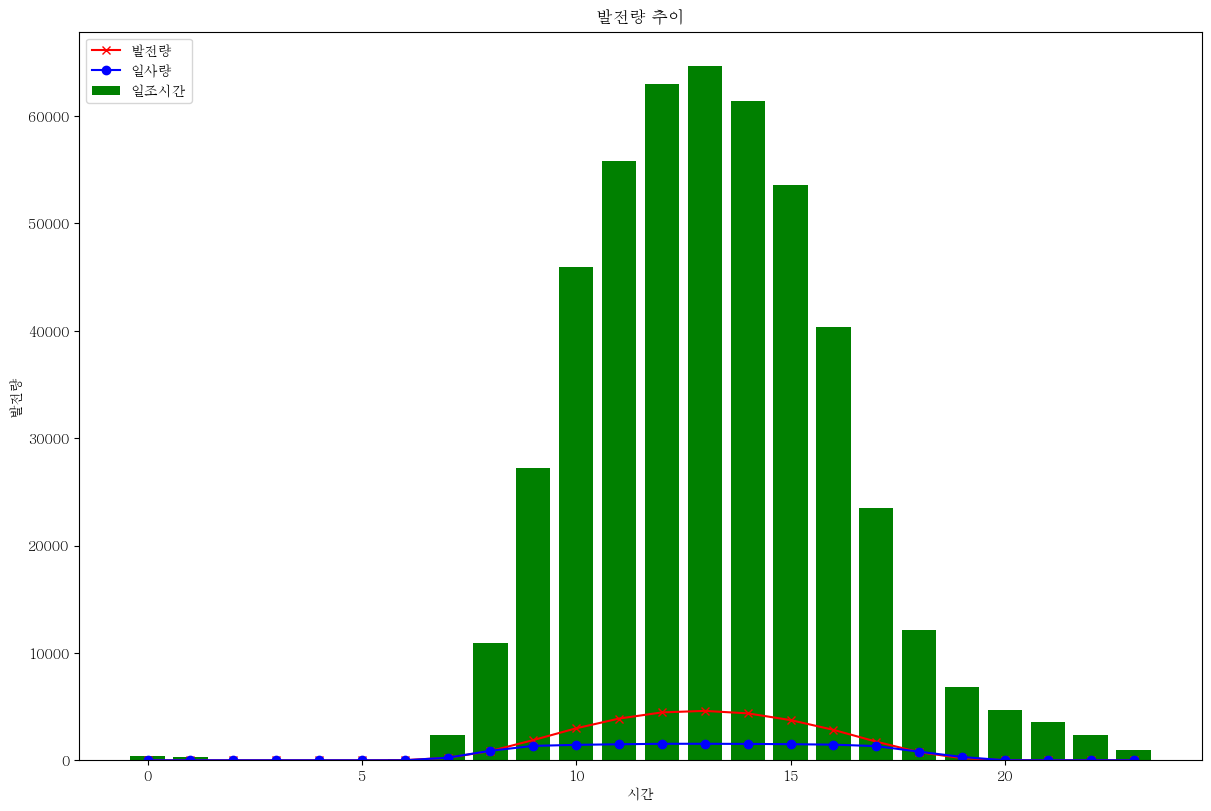

In [7]:
# 시간대별 평균 발전량 추이 분석 (bar, line)

g1 = df.groupby('시간')

gr1 = g1.sum()

fig, axe = plt.subplots(figsize=(12, 8), layout='constrained')
# fig.suptitle('시간대별 추이')

axe.set_title('발전량 추이')
axe.set_xlabel("시간")
axe.set_ylabel("발전량")

axe.bar(gr1.index, gr1['발전량'], color='g', label='발전량')
axe.plot(gr1.index, gr1['일사량'], color='r', marker='x', label='일사량')
axe.plot(gr1.index, gr1['일조시간'], color='b', marker='o', label='일조시간')
axe.legend(['발전량', '일사량', '일조시간'], loc='upper left')

# sns.relplot(data=g2, x='시간', y='발전량', kind='line')

     1. 시간대별 평균 발전량 추이 분석 (bar, line)
       - 시간대별 발전량 추이 분석을 통해 가장 발전이 잘되는 시간대 구간 확인
  
    -> 발전량이 가장 높은 시간대 : 13시
        통상(12~14시) 태양이 최대 고도에 이른 시간대에 높은 발전량 수치가 나타남

C:\Users\user\AppData\Local\Temp\ipykernel_10068\176781754.py:4: FutureWarning: ['지역'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  gr2 = g2.agg(['sum', 'mean'])
C:\Users\user\AppData\Local\Temp\ipykernel_10068\176781754.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gr3 = g2.sum()
c:\Python311\Lib\site-packages\seaborn\relational.py:982: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(


,발전량,강수량,풍속,풍향,습도,일조시간,일사량,전운량,시정
월,,,,,,,,,
1,31893.65,219.1,13711.4,1029990.0,205793.0,1329.6,1961.00,14819.0,11103766.0
2,36851.14,281.4,13437.3,883120.0,193094.0,1328.5,2347.51,14175.0,9752107.0
3,42888.51,631.7,15579.3,792990.0,264822.0,1289.7,2880.21,19220.0,9452566.0
4,47429.19,666.6,15437.0,747990.0,257611.0,1387.9,3417.10,18412.0,10499881.0
5,50744.99,513.0,15076.5,805980.0,293178.0,1514.4,3714.41,21745.0,10048057.0
6,44822.55,1354.6,13398.3,649090.0,325899.0,1318.6,3666.01,24020.0,8965988.0
7,41282.65,1996.4,13895.8,671270.0,368850.0,1147.0,3166.86,27805.0,9467387.0
8,41291.04,1463.8,15007.6,697600.0,351437.0,1250.7,2713.48,26456.0,10554842.0
9,34398.60,1481.8,13050.7,507280.0,327413.0,908.5,2286.25,27739.0,12079191.0


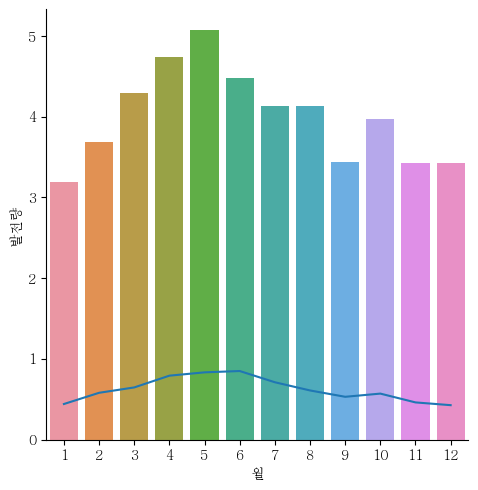

In [8]:
# 월별 합계 발전량, 합계 일조시간, 평균 일사량 추이 분석 (bar, line)
g2 = df.groupby('월')

gr2 = g2.agg(['sum', 'mean'])
gr3 = g2.sum()

gr2 = gr2.iloc[:, 6:]
gr3 = gr3.iloc[:, 3:]

# print(gr2.columns)

# sns.relplot(data=gr2, kind='line')
sns.relplot(data=gr2, x=gr2.index-1, y=('일사량','mean'), kind='line')
sns.barplot(data=gr3/10000, x=gr3.index, y='발전량')
gr3

     2. 월별 합계 발전량, 합계 일조시간, 평균 일사량 추이 분석 (bar, line)
       - 월별 합계 발전량, 합계 일조시간, 평균 일사량, 평균 강수량 추이 분석을 통해 발전 효율이 좋은 월 선정

     -> 발전 효율이 가장 좋은 달 : 5월
     * 월별 발전량, 평균일사량 추이를 봤을 때 봄 중에서도 5월에 발전량이 가장 높게 나오고 있음을 확인 수 있다.
     * 비교 사이트 출처 :https://m.blog.naver.com/haezoom/220614911325

     고찰
     * 통상 봄, 가을에 발전효율이 좋다는 통계를 바탕으로 위 차트를 해석했을 때
     * 봄(3~5), 가을(9~11월) 구간대에서 봄은 통계에 맞게 나오나, 가을의 경우 변별력이 모호한 것을 볼 수 있다.
     * 허나 지역적인 특성이 배제되어 있어 전국 데이터를 활용한다면 보다 통계에 맞는 데이터 추출이 가능할 것으로 보인다. 

In [9]:
df

,년,월,일,시간,지역,발전량,강수량,풍속,풍향,습도,일조시간,일사량,전운량,시정
0,2017,1,1,1,부산,0.00,0.0,3.6,360.0,67.0,0.0,0.0,0.0,1438.0
1,2017,1,1,2,부산,0.00,0.0,4.0,360.0,67.0,0.0,0.0,0.0,1572.0
2,2017,1,1,3,부산,0.00,0.0,1.5,360.0,69.0,0.0,0.0,0.0,1407.0
3,2017,1,1,4,부산,0.00,0.0,0.4,0.0,67.0,0.0,0.0,0.0,1392.0
4,2017,1,1,5,부산,0.00,0.0,3.3,320.0,68.0,0.0,0.0,0.0,1335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52578,2022,12,31,19,부산,2.48,0.0,2.1,250.0,48.0,0.0,0.0,0.0,4309.0
52579,2022,12,31,20,부산,3.40,0.0,2.9,250.0,51.0,0.0,0.0,0.0,3672.0
52580,2022,12,31,21,부산,2.64,0.0,1.6,200.0,50.0,0.0,0.0,0.0,3800.0
52581,2022,12,31,22,부산,1.05,0.0,2.5,230.0,52.0,0.0,0.0,0.0,3406.0
